# Analysing Superconductivity Measurements
Team: Ryan E, Ryan S, Charlie, Lin

Demonstrator: Emma

In [31]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import os

In [32]:
filename = 'data/theta0/Measurement_1_0.50_Field_0_Angle.csv'

df = pd.read_csv(filename, skiprows=11, names=['current_A','voltage_uV','time_s'], sep='\\s+')
df

,current_A,voltage_uV,time_s
0,0.002252,-0.772845,0.000
1,0.002388,-0.769311,0.046
2,0.002741,-0.761247,0.092
3,0.002574,-0.745235,0.139
4,0.002520,-0.741827,0.185
...,...,...,...
874,37.112894,46.353972,56.388
875,37.143997,46.651341,56.434
876,37.174254,46.942966,56.480
877,37.205899,47.221457,56.526


Extracting metadata by reading the file - temperature, angle and magnetic field.

In [33]:
# Step 1: Open the file and read lines manually
f = open(filename)
text = f.readlines()

# Step 2: Extract metadata, ignoring blank lines
def extract_value(lines, key):
    """Helper function to extract the value for a given key."""
    for line in lines:
        if key in line:
            return float(line.split('\t')[1].strip())  # Extract the value after tab

temperature = extract_value(text, "Temperature (K)")
angle = extract_value(text, "Angle (deg.)")
field = extract_value(text, "field / T")
print(f'T={temperature}, Angle={angle}, Field={field}')

T=77.0, Angle=0.0, Field=0.5


Quick Plot of Voltage (uV) vs Current (A): 

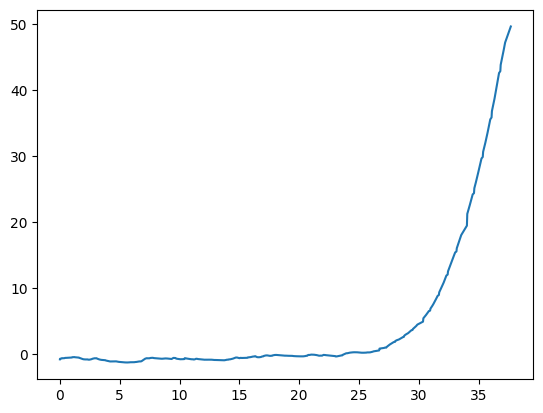

In [34]:
plt.plot(df['current_A'],df['voltage_uV'])

To find the critical current $I_C$, we read off the graph where we have an electric field E=100 uV/m. The distance between our voltage points on the sample is 0.8 cm. Therefore the voltage where this occurs is E*m = 100 uV/m * 0.008 m = 0.8 uV.

After speaking to demonstrator, we chose an electric field of 2000 uV/m instead which corresponds to a voltage V = 20 uV.

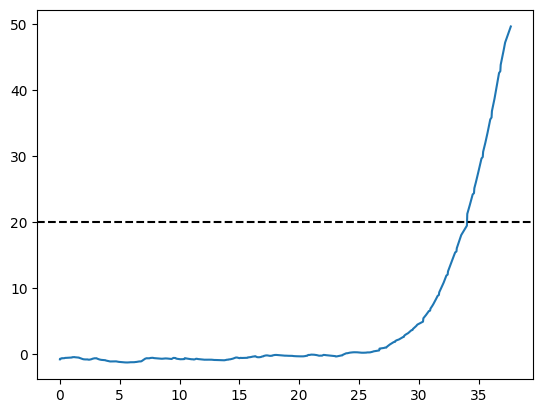

In [35]:
fig, ax = plt.subplots()
ax.plot(df['current_A'],df['voltage_uV'])
ax.axhline(20, c="black", ls="--")

In [36]:
(df['voltage_uV'] - 20).abs().idxmin()

793

In [37]:
I_c = df.loc[(df['voltage_uV'] - 20).abs().idxmin()]['current_A']

Now we have the code, we will now iterate through all the data files.

[]

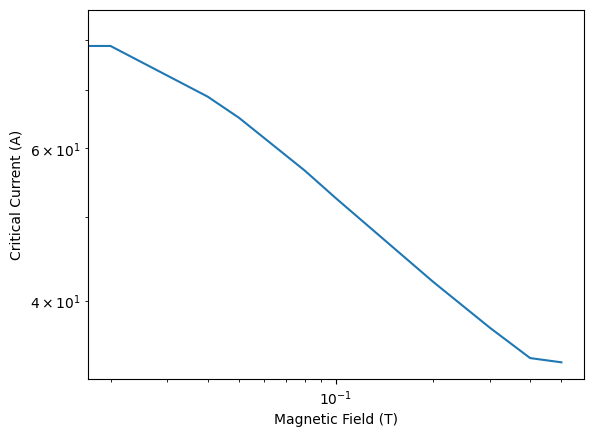

In [46]:
# Iterate through files in specified directory #
def Analyse_directory(directory):
    rows = []
    for filename in os.listdir(directory):
        try:
            file_string = os.path.join(directory, filename).replace('\\','/')   # example string: 'data/P1_B1_Idefault_Ndefault.mat'
            df = pd.read_csv(file_string, skiprows=11, names=['current_A','voltage_uV','time_s'], sep='\\s+')

        except:
            print(f"Error: Cannot load {file_string}.")

        # Extract metadata from filename
        filename_split = file_string.split("_")
        angle = float(filename_split[-2])
        field = float(filename_split[-4])

        # Find Critical Current (current value at voltage closest to 20 uV)
        I_c = df.loc[(df['voltage_uV'] - 20).abs().idxmin()]['current_A']

        # Append to our whole dataset
        row = [angle,field,I_c]
        rows.append(row)

    columns=['angle','field','I_c']
    df_Ic = pd.DataFrame(rows, columns=columns)
    return df_Ic

df_Ic_0 = Analyse_directory('data/theta0/')

fig, ax = plt.subplots()
ax.plot(df_Ic_0['field'], df_Ic_0['I_c'])
ax.set_xlabel("Magnetic Field (T)")
ax.set_ylabel("Critical Current (A)")
plt.loglog()

In [48]:
df_Ic_0 = Analyse_directory('data/theta0/')
df_Ic_45 = Analyse_directory('data/theta45/')
df_Ic_90 = Analyse_directory('data/theta90/')
df_Ic_135 = Analyse_directory('data/theta135/')


[]

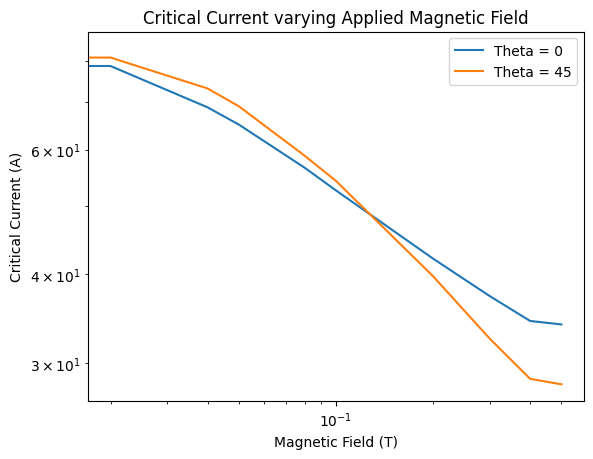

In [53]:
fig, ax = plt.subplots()
ax.plot(df_Ic_0['field'], df_Ic_0['I_c'], label="Theta = 0")
ax.plot(df_Ic_45['field'], df_Ic_45['I_c'], label="Theta = 45")
ax.set_xlabel("Magnetic Field (T)")
ax.set_ylabel("Critical Current (A)")
ax.set_title("Critical Current varying Applied Magnetic Field")
plt.legend()
plt.loglog()


[]

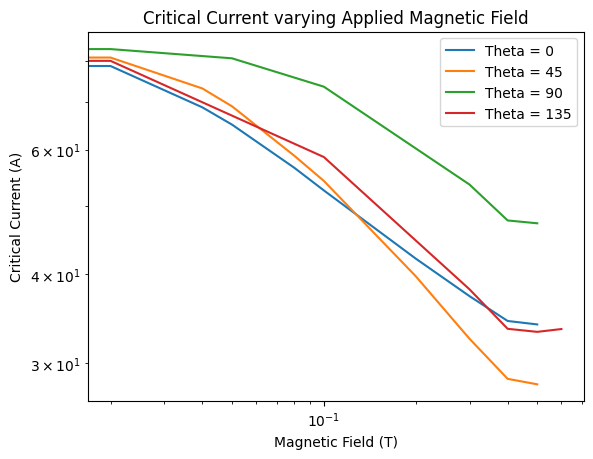

In [54]:
fig, ax = plt.subplots()
ax.plot(df_Ic_0['field'], df_Ic_0['I_c'], label="Theta = 0")
ax.plot(df_Ic_45['field'], df_Ic_45['I_c'], label="Theta = 45")
ax.plot(df_Ic_90['field'], df_Ic_90['I_c'], label="Theta = 90")
ax.plot(df_Ic_135['field'], df_Ic_135['I_c'], label="Theta = 135")
ax.set_xlabel("Magnetic Field (T)")
ax.set_ylabel("Critical Current (A)")
ax.set_title("Critical Current varying Applied Magnetic Field")
plt.legend()
plt.loglog()
